#### This notebook fits an Recurring Neural Network over Headlines dataset for sarcasm detection.

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import hstack
from normalizer import Normalizer
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dropout

tf.device = tf.device("gpu")

First let's set our envoringment to GPU!

Load the dataset:

In [2]:
data = pd.read_json("../dataset/Sarcasm_Headlines_Dataset.json", lines = True)

Explore the data:

In [3]:
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


Check if the datatset is balanced?

In [5]:
len(data.loc[data["is_sarcastic"]==0])

14985

In [6]:
len(data.loc[data["is_sarcastic"]==1])

11724

The dataset is unbalanced let's balance it!

In [7]:
sarcastic_data = data.loc[data["is_sarcastic"]==1]
nonsarcastic_data = data.loc[data["is_sarcastic"]==0][:11724]

data = pd.concat([sarcastic_data, nonsarcastic_data])
data.head(5)

,article_link,headline,is_sarcastic
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
8,https://politics.theonion.com/top-snake-handle...,top snake handler leaves sinking huckabee camp...,1
15,https://entertainment.theonion.com/nuclear-bom...,nuclear bomb detonates during rehearsal for 's...,1
16,https://www.theonion.com/cosby-lawyer-asks-why...,cosby lawyer asks why accusers didn't come for...,1


Now the dataset is balanced.

In [8]:
data = data.drop(columns=["article_link"])

Seperate the labels from the text.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23448 entries, 2 to 20970
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      23448 non-null  object
 1   is_sarcastic  23448 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 549.6+ KB


In [10]:
data = data.sample(frac=1).reset_index(drop=True)

In [11]:
X = data["headline"]
y = data["is_sarcastic"]

Now using the Normalization package that we created before, let's vectorize the text:

In [12]:
X_matrix = Normalizer().get_embeddings(pd.DataFrame({"text": X}))


[INFO] Trying to create word embeddings for this dataframe using Word2Vec model..
[INFO] Extracting columns containing text from dataframe.
[INFO] Successfully extracted text columns from the dataset.
[INFO] Applying Normalization over text:
[INFO]       - Converting Text into lower case for caseconsistency.
[INFO]       - Extracting only words containing alphabets.
[INFO] Text Normalization is now complete.
[INFO] Attempting further preprocessing using Tokenizer()


[INFO] Fitting a Word2Vec model for this text.
[INFO] Creating an embedding matrix!
[INFO] Word embeddings created! Successfully!


Let's split the set into validation and train set:

In [13]:
X_train, X_Test, y_train, y_test = train_test_split(X_matrix, y, test_size=0.33, random_state=42)

In [14]:
X_train.shape

(15710, 100, 100)

Now that we have the necessary datasets ready let's fit an RNN to it.

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

sequence_length = X_train.shape[1]
embedding_dimension = X_train.shape[2]

model = Sequential()

model.add(LSTM(32, activation='tanh', input_shape=(sequence_length, embedding_dimension), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(16, activation='tanh', return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005)  # Increased learning rate a bit
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


model.summary()
 # Display the model architecture

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 100, 32)           17024     
                                                                 
 dropout_8 (Dropout)         (None, 100, 32)           0         
                                                                 
 lstm_9 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 20177 (78.82 KB)
Trainable params: 20177 (78.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
history = model.fit(X_train, y_train, epochs=25, batch_size=64, validation_data=(X_Test, y_test))


Epoch 1/25
246/246 [==============================] - 14s 45ms/step - loss: 0.6939 - accuracy: 0.5010 - val_loss: 0.6936 - val_accuracy: 0.4968
Epoch 2/25
246/246 [==============================] - 10s 42ms/step - loss: 0.6937 - accuracy: 0.4945 - val_loss: 0.6932 - val_accuracy: 0.4968
Epoch 3/25
246/246 [==============================] - 11s 45ms/step - loss: 0.6936 - accuracy: 0.4957 - val_loss: 0.6942 - val_accuracy: 0.4968
Epoch 4/25
246/246 [==============================] - 12s 47ms/step - loss: 0.6935 - accuracy: 0.5022 - val_loss: 0.6933 - val_accuracy: 0.4968
Epoch 5/25
246/246 [==============================] - 10s 42ms/step - loss: 0.6935 - accuracy: 0.4937 - val_loss: 0.6931 - val_accuracy: 0.5032
Epoch 6/25
246/246 [==============================] - 10s 42ms/step - loss: 0.6934 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.4968
Epoch 7/25
246/246 [==============================] - 10s 42ms/step - loss: 0.6933 - accuracy: 0.4985 - val_loss: 0.6931 - val_accuracy:

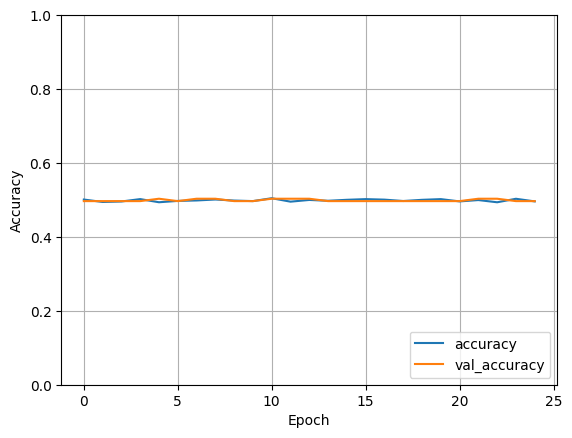

In [25]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid()
plt.show()

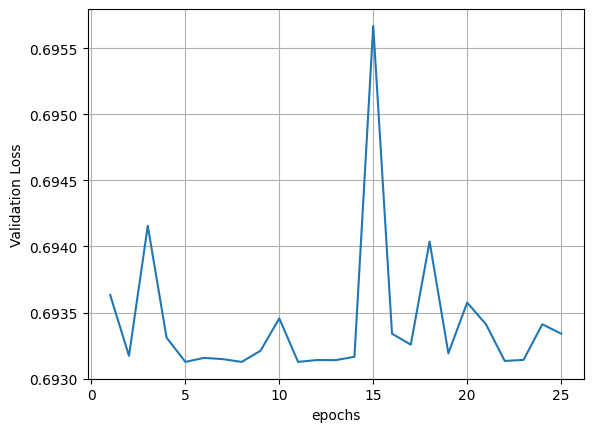

In [26]:
losses = history.history["val_loss"]
plt.plot(range(1,26), losses)
plt.xlabel("epochs")
plt.ylabel("Validation Loss")
plt.grid()
plt.show()

In [27]:
y_pred = model.predict(X_Test)


242/242 [==============================] - 3s 9ms/step


In [28]:
from sklearn.metrics import classification_report
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)


report = classification_report(y_test, y_pred_binary)
print(report)

              precision    recall  f1-score   support

           0       0.50      1.00      0.66      3844
           1       0.00      0.00      0.00      3894

    accuracy                           0.50      7738
   macro avg       0.25      0.50      0.33      7738
weighted avg       0.25      0.50      0.33      7738



c:\Users\Sanju\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sanju\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sanju\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,